<a href="https://colab.research.google.com/github/yudahendriawan/google-colab-projects/blob/time-series/time_series_submission_yuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [38]:
data_train = pd.read_csv('/content/drive/MyDrive/google-colab-datasets/HistoricalData_1706706395156.csv')
data_train.head()

,Date,Close/Last,Volume,Open,High,Low
0,01/30/2024,188.04,55859370,190.94,191.80,187.47
1,01/29/2024,191.73,47145620,192.01,192.20,189.58
2,01/26/2024,192.42,44594010,194.27,194.76,191.94
3,01/25/2024,194.17,54822130,195.22,196.27,193.11
4,01/24/2024,194.50,53631320,195.42,196.38,194.34


In [39]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1258 non-null   object 
 1   Close/Last  1258 non-null   float64
 2   Volume      1258 non-null   int64  
 3   Open        1258 non-null   float64
 4   High        1258 non-null   float64
 5   Low         1258 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [40]:
data_train.isnull().sum()


Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [41]:
scaler = MinMaxScaler()
data_train['Volume'] = scaler.fit_transform(data_train[['Volume']])

In [42]:
data_train.head()

,Date,Close/Last,Volume,Open,High,Low
0,01/30/2024,188.04,0.078968,190.94,191.80,187.47
1,01/29/2024,191.73,0.057337,192.01,192.20,189.58
2,01/26/2024,192.42,0.051003,194.27,194.76,191.94
3,01/25/2024,194.17,0.076393,195.22,196.27,193.11
4,01/24/2024,194.50,0.073437,195.42,196.38,194.34


Text(0.5, 1.0, "Volume of Apple's trading")

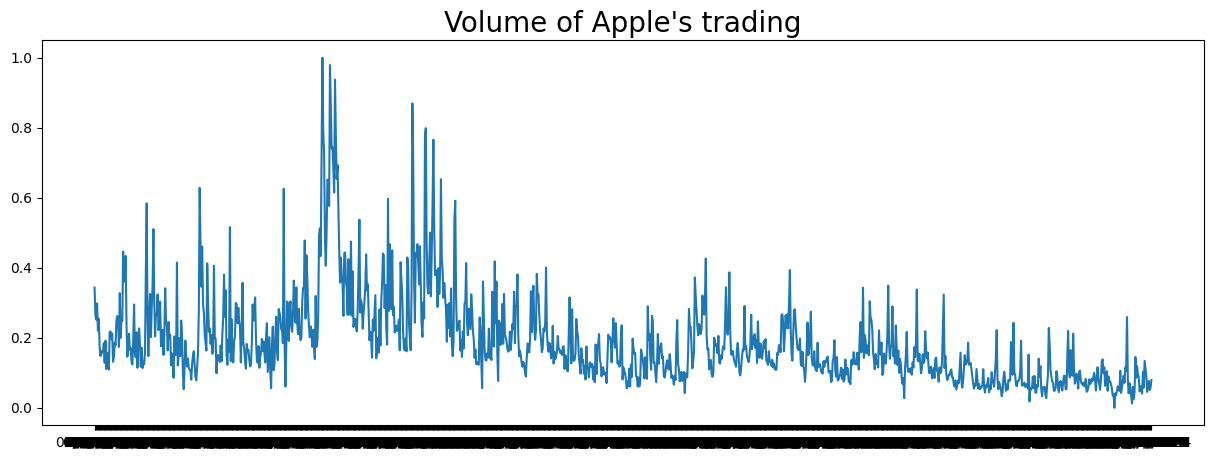

In [43]:
dates = data_train['Date'][::-1].values
volumes = data_train['Volume'][::-1].values

volumes = volumes.astype(np.float32)

plt.figure(figsize=(15,5))
plt.plot(dates, volumes)
plt.title('Volume of Apple\'s trading', fontsize=20)

In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [45]:
threshold_mae = (volumes.max()-volumes.min())*10/100
threshold_mae

0.1

In [46]:
date_train, date_test, volume_train, volume_test = train_test_split(dates, volumes, test_size=0.2, shuffle=False)

In [47]:
len(volume_test)

252

In [48]:
train_set = windowed_dataset(volume_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(volume_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ]
)

In [49]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae):
      print("\nMAE telah mencapai <10% dari skala data!")
      self.model.stop_training = True

callbacks = MyCallback()

history = model.fit(train_set, epochs=100, callbacks=[callbacks], validation_data = test_set)

Epoch 1/100
10/10 [==============================] - 4s 99ms/step - loss: 0.0176 - mae: 0.1386 - val_loss: 0.0125 - val_mae: 0.1531
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0106 - mae: 0.1195 - val_loss: 0.0125 - val_mae: 0.1529
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0084 - mae: 0.0873
MAE telah mencapai <10% dari skala data!
10/10 [==============================] - 0s 21ms/step - loss: 0.0084 - mae: 0.0873 - val_loss: 0.0041 - val_mae: 0.0854


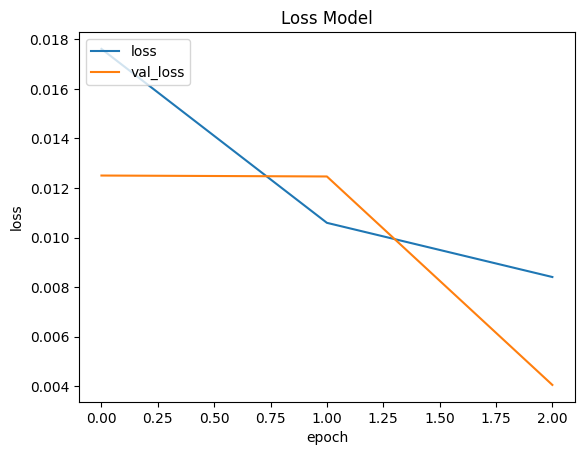

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

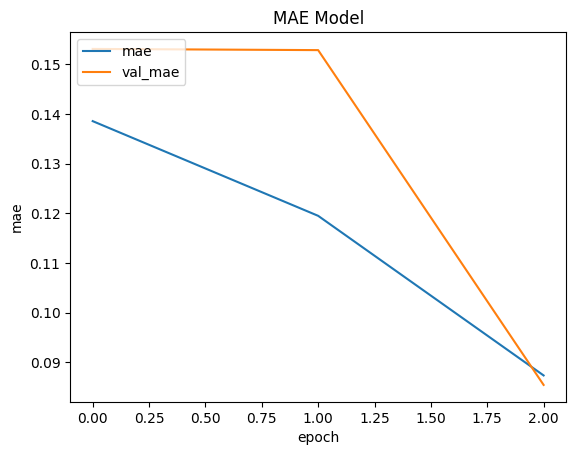

In [51]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'], loc='upper left')
plt.show()